Sena Ezgi Anadollu - 201401017
Beyza Altanlar - 151101040

In [1]:
import sys

sys.executable


'/Users/ezgi/opt/anaconda3/bin/python'

In [1]:
import pyspark as spark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *

In [3]:
spark=SparkSession.builder.appName('FlightPricePrediction').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/05 18:04:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:

df_pyspark=spark.read.csv('Clean_Dataset.csv',header=True,inferSchema=True)
df_pyspark.show()

+-----+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|index|  airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+-----+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|    0| SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
|    1| SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|    2|  AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|    3|  Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|    4|  Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
|    5|  Vistara

Columns are categorized based on which type of data they have.

In [5]:
continuous_features = ['duration', 'days_Left', 'price']
categorical_features = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

In [6]:
df_pyspark.select(continuous_features).describe().toPandas()

,summary,duration,days_Left,price
0,count,300153,300153,300153
1,mean,12.221020812719066,26.004750910369044,20889.660523133203
2,stddev,7.191997238119004,13.56100368709358,22697.767366074422
3,min,0.83,1,1105
4,max,49.83,49,123071


In [7]:
df_pyspark.printSchema()


root
 |-- index: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- flight: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- price: integer (nullable = true)



In [8]:
df_pyspark.count()

300153

The dataset includes 300153 flight reservation options

In [9]:
df_pyspark.distinct().count()

300153

All values are distinct

In [10]:
df_pyspark_dropped = df_pyspark.na.drop()
df_pyspark_dropped.count()

300153

There is not any null value

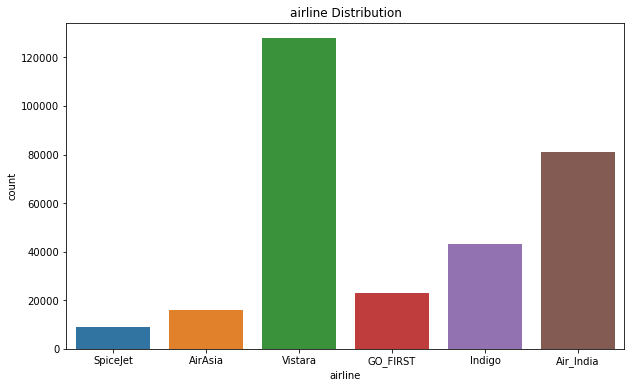

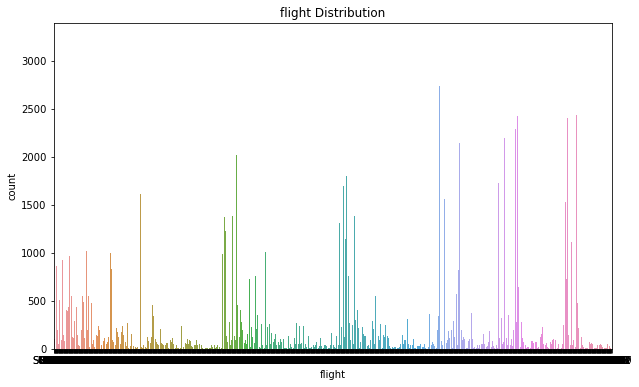

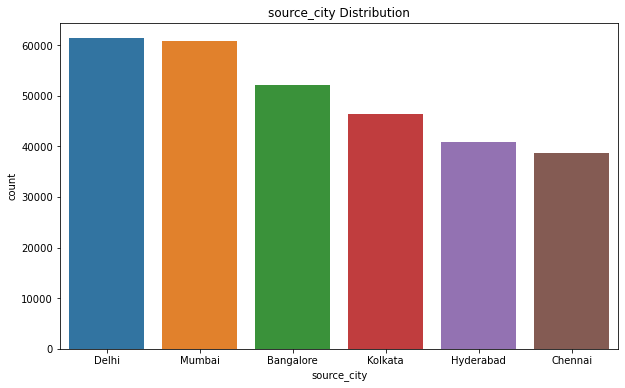

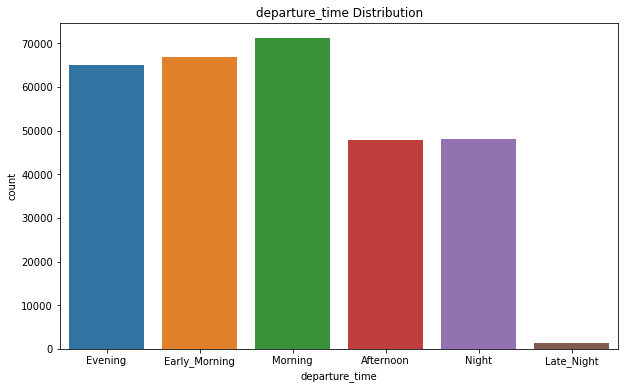

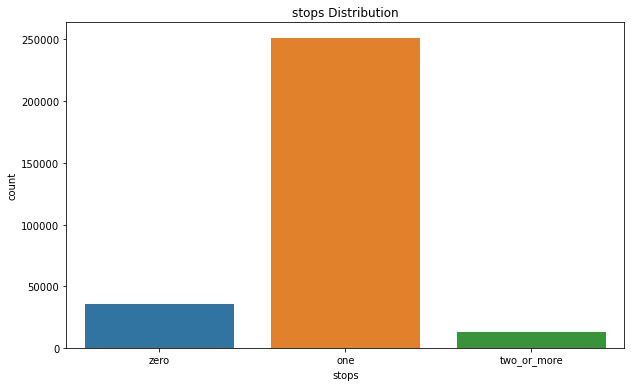

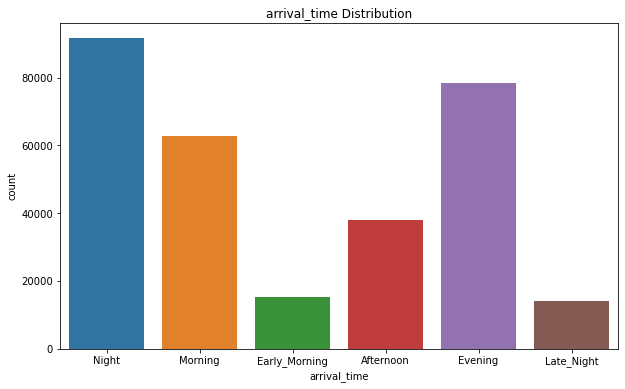

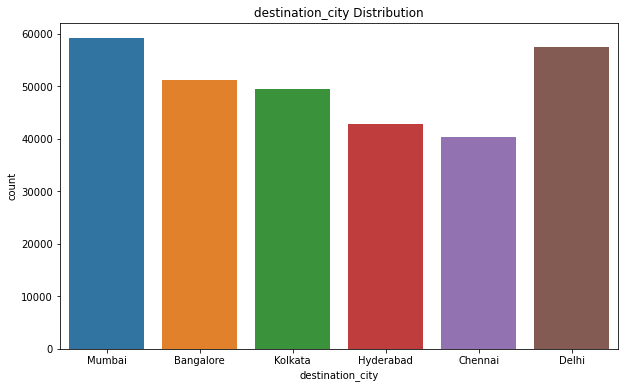

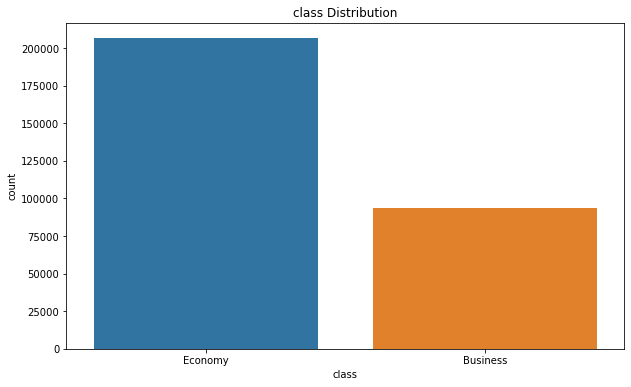

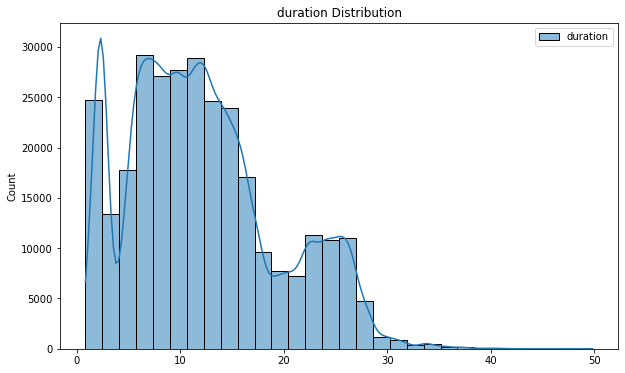

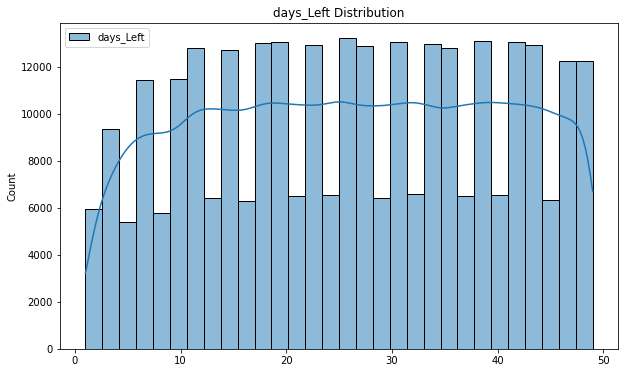

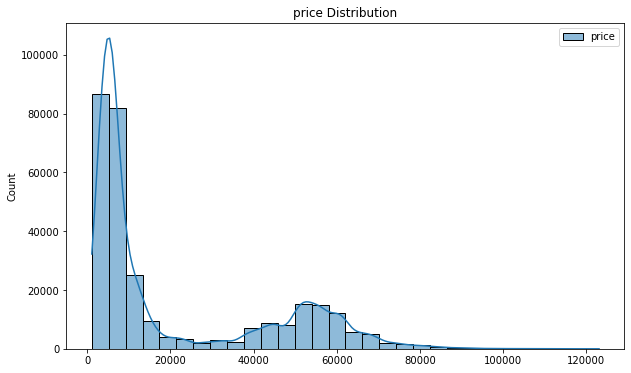

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# Distribution for categorical variables
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, data=df_pyspark.toPandas())
    plt.title(f"{feature} Distribution")
    plt.show()

# Distribution for continuous variables
for feature in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_pyspark.select(col(feature)).toPandas(), bins=30, kde=True)
    plt.title(f"{feature} Distribution")
    plt.show()


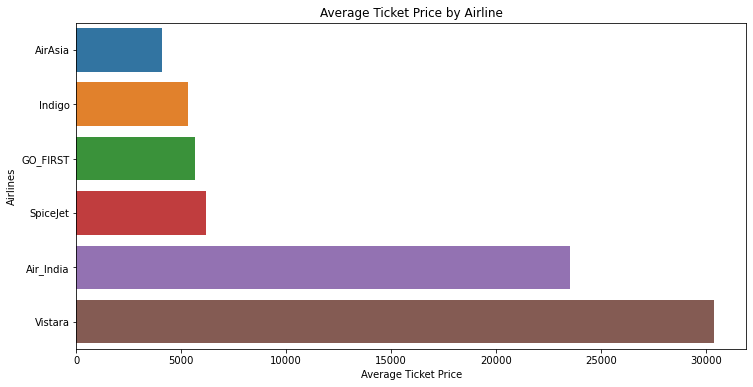

In [12]:
# Group by Airline and calculate average price
avg_price_by_airline = df_pyspark.groupBy("airline").agg({"price": "avg"}).sort("avg(price)")

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x="avg(price)", y="airline", data=avg_price_by_airline.toPandas())
plt.title("Average Ticket Price by Airline")
plt.xlabel("Average Ticket Price")
plt.ylabel("Airlines")
plt.show()



Airline Vista has the highest average ticket price

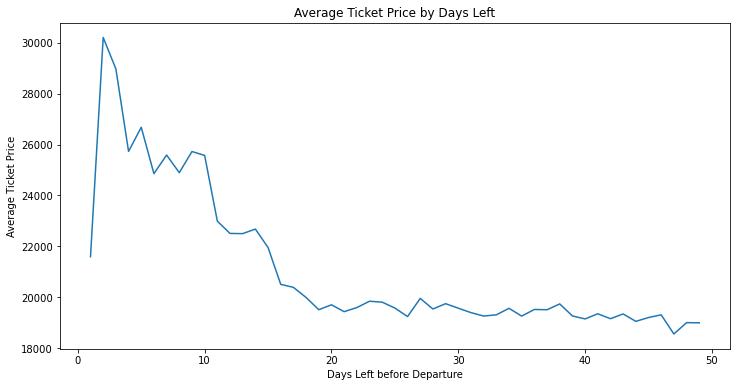

In [13]:
# Group by Days Left and calculate average price
avg_price_by_days_left = df_pyspark.groupBy("days_left").agg({"price": "avg"}).sort("days_left")

# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x="days_left", y="avg(price)", data=avg_price_by_days_left.toPandas())
plt.title("Average Ticket Price by Days Left")
plt.xlabel("Days Left before Departure")
plt.ylabel("Average Ticket Price")
plt.show()

Prices generally increase as the departure date approaches. However, there is a slight dip in prices for tickets booked a day or two before departure

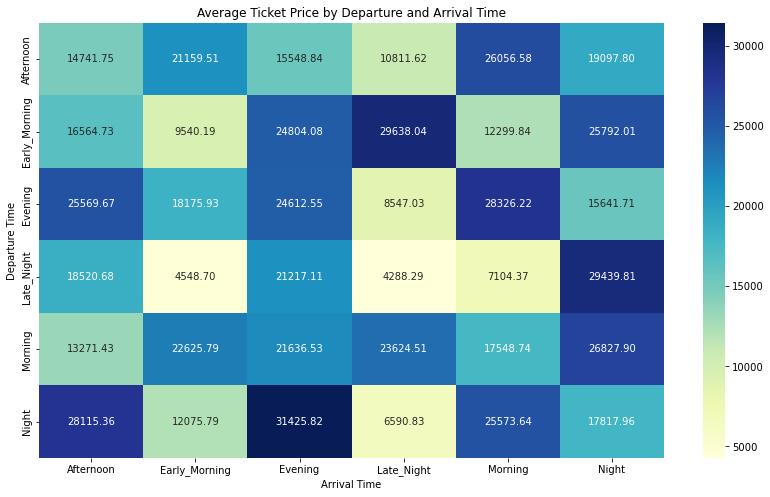

In [14]:
# Group by Departure Time and Arrival Time and calculate average price
avg_price_by_time = df_pyspark.groupBy("departure_time", "arrival_time").agg({"price": "avg"})

# Convert PySpark DataFrame to Pandas DataFrame for visualization
avg_price_by_time_pd = avg_price_by_time.toPandas()

# Visualization
plt.figure(figsize=(14, 8))
sns.heatmap(
    avg_price_by_time_pd.pivot("departure_time", "arrival_time", "avg(price)"),
    annot=True,
    cmap="YlGnBu",
    fmt=".2f"
)
plt.title("Average Ticket Price by Departure and Arrival Time")
plt.xlabel("Arrival Time")
plt.ylabel("Departure Time")
plt.show()




Flights departing in the early morning or late evening, especially with midday arrivals, tend to have lower prices. In contrast, peak travel times during the day exhibit higher average prices.

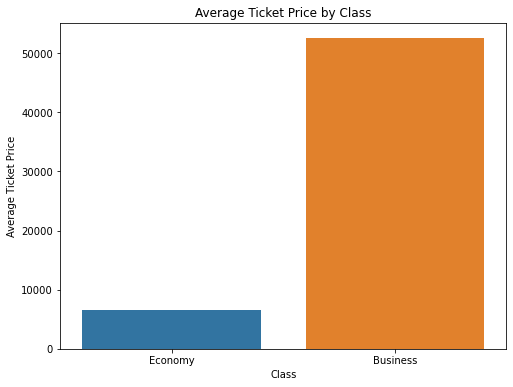

In [15]:

# Group by Class and calculate average price
avg_price_by_class = df_pyspark.groupBy("class").agg({"price": "avg"})

# Convert PySpark DataFrame to Pandas DataFrame for visualization
avg_price_by_class_pd = avg_price_by_class.toPandas()

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(x="class", y="avg(price)", data=avg_price_by_class_pd)
plt.title("Average Ticket Price by Class")
plt.xlabel("Class")
plt.ylabel("Average Ticket Price")
plt.show()

Business class tickets are considerably more expensive than Economy class tickets

In [16]:
# Create a function to use for creating new column

def identify_same_pairs(route):
    cities = route.split(" to ")
    return "-".join(sorted(cities))



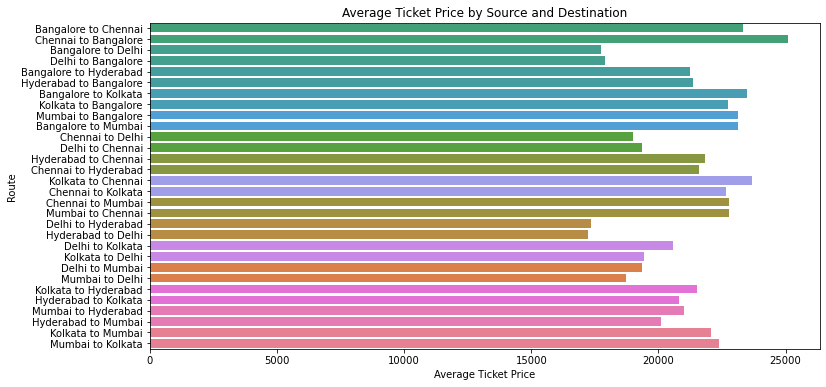

In [17]:
# Group by Source City and Destination City and calculate average price
avg_price_by_route = df_pyspark.groupBy("source_city", "destination_city").agg({"price": "avg"})

# Convert PySpark DataFrame to Pandas DataFrame for visualization  
avg_price_by_route_pd = avg_price_by_route.toPandas()

# Add "Route" and "Sorted Route" columns to use for sorting
avg_price_by_route_pd["Route"] = avg_price_by_route_pd["source_city"] + " to " + avg_price_by_route_pd["destination_city"]
avg_price_by_route_pd["Sorted Route"] = avg_price_by_route_pd["Route"].apply(identify_same_pairs)

# Sort DataFrame based on the new "Route" column
avg_price_by_route_pd_sorted = (
    avg_price_by_route_pd.sort_values(by="Sorted Route")
    .reset_index(drop=True)
)

# Create a color palette 
color_palette = sns.color_palette("husl", n_colors=len(avg_price_by_route_pd_sorted) // 2)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    x="avg(price)",
    y="Route",
    data=avg_price_by_route_pd_sorted,
    palette=sorted(color_palette * 2 ) # Repeat the color palette for each pair

)
plt.title("Average Ticket Price by Source and Destination")
plt.xlabel("Average Ticket Price")
plt.ylabel("Route")
plt.show()





routes involving Delhi have lower prices while routes involving Chennai have higher prices than other cities.